# **Imports :**

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
import numpy as np
import datetime
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.layers import Layer, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip,RandomContrast , RandomRotation, Resizing, Rescaling
from tensorflow.keras.regularizers  import L2, L1
import tensorflow_probability as tfp
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns ###
from tensorflow.keras.losses import BinaryCrossentropy , Loss
from tensorflow.keras.metrics import Metric ,  BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from google.colab import drive
#import albumentations as A
from tensorflow.keras.callbacks import TensorBoard , LearningRateScheduler , Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds


In [5]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    }

# **Data Preparation :**


### Data Loading :


In [6]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteY1UDWM/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
dataset
#prefetchedDataset maaneha  we have sotocked the dataset malaria locally ,
#element_spect are the element of our dataset , which are features ( images) and labels (classes )

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [6]:
dataset[0]

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
data = dataset[0].take(1)
data #its a takedataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
rank_3_tensor = tf.constant([
  [[0, 1, 2, 3, 4],
   [5, 6, 7, 8, 9]],

  [[10, 11, 12, 13, 14],
   [15, 16, 17, 18, 19]],

  [[20, 21, 22, 23, 24],
   [25, 26, 27, 28, 29]],
  ])

In [10]:
print(rank_3_tensor)


tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]], shape=(3, 2, 5), dtype=int32)


In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [25]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
   DATASET_SIZE = len(dataset)
   train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
   val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
   val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
   test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
   return train_dataset, val_dataset, test_dataset

In [42]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

In [43]:
val_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
#print(list(train_dataset.take(1))[0][0])
#print(list(train_dataset.take(1).as_numpy_iterator())[0][0])
#as_numpy_iterator() pour l'iterer comme array et non pas trensor
# whithout hte list its an object , with the list we will have the continue in the list

# **Dataset Visualization :**


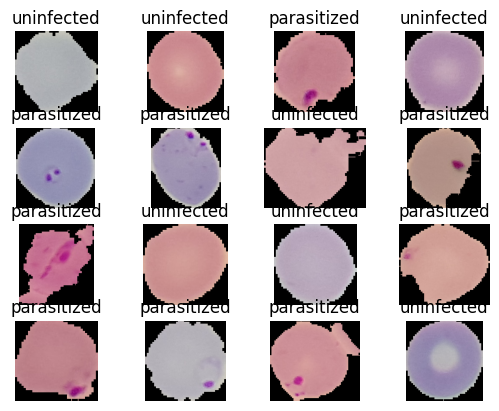

In [16]:
for i, (image, label) in enumerate(train_dataset.take(16)):
   ax = plt.subplot(4, 4, i + 1)
   plt.imshow(image)
   plt.title(dataset_info.features['label'].int2str(label))
   plt.axis('off')

# **Data Preprocessing :**


In [17]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)
  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [18]:
original_image, label = next(iter(train_dataset))

## **Normalisation : resize and rescale :**

In [8]:
IM_SIZE = 224

In [36]:
@tf.function
def resize_rescale(image, label):
  #print("I was here")
  #tf.print("I was here")
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255, label

In [10]:
# tf.keras.layer resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
     Resizing(IM_SIZE, IM_SIZE),
     Rescaling(1./255),
     ])

## **Data Augmentation :**


In [11]:
### tf.image augment
@tf.function
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

  return image, label

In [12]:
### with class
class RotNinety(Layer):
   def __init__(self):
    super.__init__()

    @tf.function
    def call(self ,image):
      return tf.image.rot90(image)

In [13]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501)),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),
])

In [14]:
@tf.function
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

### **MIxup Data Augmentation : sommation de deux images**

In [16]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))
mixed_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)))>

In [17]:
@tf.function

def mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label

In [18]:
train_dataset = (
     mixed_dataset
    .shuffle(buffer_size = 4096, reshuffle_each_iteration = True)
    .map(mixup)
)

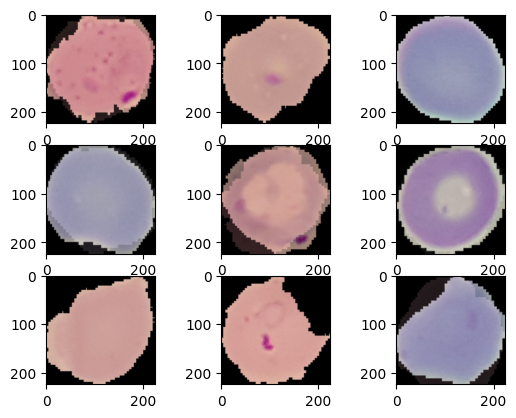

In [19]:
for i , (a,b) in enumerate(train_dataset.take(9)):
  ax = plt.subplot( 3  , 3 , i +1 )
  plt.imshow(a)

### CutMix Data *Augmentation* : metter des images sur des autres:

In [20]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 4096, )
train_dataset_2 = train_dataset.shuffle(buffer_size = 4096, )

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [21]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [22]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [23]:
BATCH_SIZE = 32
train_dataset = (
     mixed_dataset
    .shuffle(buffer_size = 4096, reshuffle_each_iteration = True)
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i , (a,b) in enumerate(train_dataset.take(9)):
  ax = plt.subplot( 3  , 3 , i +1 )
  plt.imshow(a[0])

### **Albumentation :**

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
transforms = A.Compose([
      A.Resize(IM_SIZE, IM_SIZE),

      A.OneOf([A.HorizontalFlip(),
                A.VerticalFlip(),], p = 0.3),

      A.RandomRotate90(),
      #A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
      #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
      A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])

In [ ]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image

In [ ]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    aug_img.set_shape((IM_SIZE, IM_SIZE, 3))
    return aug_img, label

In [ ]:
train_dataset = train_dataset.map(process_data)

In [ ]:
for i in train_dataset.take(1):
  print(i)
  break

In [ ]:
#for i , (a,b) in enumerate(train_dataset.take(9)):
  ax = plt.subplot(3  ,3 ,i +1)
  plt.imshow(a)

In [ ]:
train_dataset

In [ ]:
train_dataset.take(1)

### **Repeating the dataset (x5)**

In [ ]:
def augment_1(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.random_brightness(image, 0.2)
  return image, label

In [ ]:
def augment_2(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.random_flip_up_down(image)
  return image, label

In [ ]:
def augment_3(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.flip_left_right(image)
  return image, label

In [ ]:
def augment_4(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  return image, label

In [ ]:
def augment_5(image, label):
  image, label = resize_rescale(image, label)

  return image, label

In [ ]:
train_dataset_1 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_1)
)

In [ ]:
train_dataset_2 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_2)
)

In [ ]:
train_dataset_3 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_3)
)

In [ ]:
train_dataset_4 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_4)
)

In [ ]:
train_dataset_5 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_5)
)

In [ ]:
full_dataset = train_dataset_1.concatenate(train_dataset_2).concatenate(train_dataset_3).concatenate(train_dataset_4).concatenate(train_dataset_5)

In [ ]:
full_dataset

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
full_dataset = (
    full_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# MODELING  :

In [23]:
CONFIGURATION = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 3,
  "BATCH_SIZE": 32,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 20,
  "N_DENSE_2": 5,
}

IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

In [24]:
###https://poloclub.github.io/cnn-explainer/
seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS ,
          kernel_size = KERNEL_SIZE,
          strides = N_STRIDES ,
          padding='valid',
          activation = 'relu',
          kernel_regularizer = L2(REGULARIZATION_RATE)),

    BatchNormalization(),

    MaxPool2D(pool_size = POOL_SIZE,
              strides= N_STRIDES*2),
              Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4,
           kernel_size = KERNEL_SIZE,
           strides=N_STRIDES,
           padding='valid',
           activation = 'relu',
           kernel_regularizer = L2(REGULARIZATION_RATE)),

    BatchNormalization(),

    MaxPool2D (pool_size = POOL_SIZE,
               strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'],
          activation = "relu",
           kernel_regularizer = L2(REGULARIZATION_RATE)),

    BatchNormalization(),


    Dense( CONFIGURATION['N_DENSE_2'],
          activation = "relu",
          kernel_regularizer = L2(REGULARIZATION_RATE)),

    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      6

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),])

feature_extractor_seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

# **Model Subclassing**

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

# **Functional API:**

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)
#x = feature_sub_classed(func_input) # with the subclass method


x = Flatten()(x)

x = Dense(120, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(84, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

func_model = Model(func_input, func_output, name = "func_model")
func_model.summary()

Model: "func_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 120)               5598840   
                                                                 
 batch_normalization_8 (Bat  (None, 120)               480       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 84)                10164     
                                                        

In [ ]:
class ClassModel(Model):
  def __init__(self):
    super(ClassModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

sub_classed_model = ClassModel()
sub_classed_model(tf.zeros([1,224,224,3])) #initilaisation du model ::::: construction du modole
sub_classed_model.summary()

Model: "class_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_12 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_13 (Ba  multiple                  

# **Customisation**

## Layer :

In [ ]:
class CusomDense(Layer):
  def __init__(self, output_units, activation):
    super(CusomDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal",)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", )

  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)

    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output

## model

In [ ]:
IM_SIZE = 224
custom_seq_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Flatten(),

                             CusomDense(100, activation = "relu"),
                             BatchNormalization(),

                             CusomDense(10, activation = "relu"),
                             BatchNormalization(),

                             CusomDense(1, activation = "sigmoid"),

])
custom_seq_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_14 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_15 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

## Loss Class

In [ ]:
class CustomBCE(Loss):
  def __init__(self, FACTOR):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR
  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* self.FACTOR

In [ ]:
def custom_bce(FACTOR):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* FACTOR
  return loss

In [ ]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

## accuracy

In [ ]:
class CustomAccuracy(Metric):
  def __init__(self, name = 'Custom_Accuracy', FACTOR = 1):
    super(CustomAccuracy, self).__init__()
    self.FACTOR = FACTOR
    self.accuracy = self.add_weight(name = name, initializer = 'zeros')

  def update_state(self, y_true, y_pred, sample_weight = None):
    output = binary_accuracy(tf.cast(y_true, dtype = tf.float32), y_pred)*self.FACTOR
    self.accuracy.assign(tf.math.count_nonzero(output, dtype = tf.float32)/tf.cast(len(output), dtype = tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)

In [ ]:
def custom_accuracy(y_true, y_pred):
  return binary_accuracy(y_true, y_pred)

In [ ]:
def custom_accuracy(FACTOR):
  def metric(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)* FACTOR
  return metric

# Custon Training loop :

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = CONFIGURATION['N_EPOCHS']

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/val'

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
      y_pred = seq_model(x_batch, training = True)
      loss = custom_bce(y_batch, y_pred)

  #wandb.log({'loss':loss.numpy()})
  partial_derivatives = recorder.gradient(loss, seq_model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, seq_model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
    y_pred_val = seq_model(x_batch_val, training = False)
    loss_val = custom_bce(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    return loss_val

In [ ]:
def malaria_custom_model(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}".format(epoch+1))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch)

    print("Training Loss", loss)
    print("The accuracy is: ", METRIC.result())

    with custom_train_writer.as_default():
      tf.summary.scalar('Training Loss', data = loss, step = epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Training Accuracy', data = METRIC.result(), step = epoch)

    METRIC.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val, y_batch_val)

    print("The Validation loss", loss_val)
    print("The Validation accuracy is: ", METRIC_VAL.result())

    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Loss', data = loss_val, step = epoch)
    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Accuracy', data = METRIC_VAL.result(), step = epoch)

    METRIC_VAL.reset_states()
  print("Training Complete!!!!")

In [ ]:
malaria_custom_model(custom_seq_model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

# Training

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

In [ ]:
BATCH_SIZE = 32
val_dataset = (
     val_dataset
    .map(resize_rescale)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
seq_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
      loss = BinaryCrossentropy(),
      #metrics = metrics
                 )

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
history = seq_model.fit(train_dataset,epochs = 1, validation_data=val_dataset ,
                        callbacks=[tensorboard_callback , checkpoint_callback]
                       )

689/689 [==============================] - ETA: 0s - loss: 0.4493WARNING:tensorflow:Can save best model only with val_precision available, skipping.


689/689 [==============================] - 108s 142ms/step - loss: 0.4493 - val_loss: 0.2452


# Callback

## Custom

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))
  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [ ]:
class LogImagesCallbackTensorBoard(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = seq_model.predict(np.array(inp)[:,0,...])

    threshold = 0.5

    cm = confusion_matrix(labels, predicted > threshold)

    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image = tf.image.decode_png(buffer.getvalue(), channels=3)
    image = tf.expand_dims(image, axis = 0)

    CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
    IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
    image_writer = tf.summary.create_file_writer(IMAGE_DIR)

    with image_writer.as_default():
      tf.summary.image("Training data", image, step = epoch)

In [ ]:
### LearningRateScheduler
def scheduler(epoch, lr):

  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()

  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

## from keras.callbacks:

In [ ]:
### ModelCheckpointing : un callback pour sauvegarder les poids du meilleur modèle
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_precision', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

In [ ]:
### ReduceLearningRateOnPlateau :un callback d'arrêt anticipé
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%Y - %H%M%S')

In [ ]:
LOG_DIR = './logs/'+ CURRENT_TIME

In [ ]:
### un callback pour TensorBoard
tensorboard_callback = TensorBoard(
    log_dir=LOG_DIR, histogram_freq = 1, profile_batch = '100,132'
)

In [ ]:
pip install -U tensorboard_plugin_profile

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 4160), started 2:34:31 ago. (Use '!kill 4160' to kill it.)

# Hyperparameter Tuning

In [ ]:
IM_SIZE = 224
def model_tune(hparams):
  seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu',kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = hparams[HP_DROPOUT]),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),

    Dense( hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),

    Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
  ])

  seq_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

  seq_model.fit(val_dataset, epochs=2)
  results = seq_model.evaluate(val_dataset)
  accuracy = results[1]
  return accuracy

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([32,64]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([32,64]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.2,0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout_rate,
              HP_REGULARIZATION_RATE: regularization_rate,
              HP_LEARNING_RATE: learning_rate,

          }
          file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

          with file_writer.as_default():
              hp.hparams(hparams)
              accuracy = model_tune(hparams)
              tf.summary.scalar('accuracy', accuracy, step = 0)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
          run_number += 1

Epoch 1/2
87/87 [==============================] - 19s 149ms/step - loss: 1.8140 - accuracy: 0.5858
Epoch 2/2
87/87 [==============================] - 7s 28ms/step - loss: 1.7280 - accuracy: 0.5662
For the run 0, hparams num_units_1:32, num_units_2:32, dropout:0.2, regularization_rate:0.01, learning_rate:0.0001
Epoch 1/2
87/87 [==============================] - 22s 155ms/step - loss: 1.8592 - accuracy: 0.6018
Epoch 2/2
87/87 [==============================] - 7s 29ms/step - loss: 1.6198 - accuracy: 0.4947
For the run 1, hparams num_units_1:32, num_units_2:32, dropout:0.2, regularization_rate:0.01, learning_rate:0.001
Epoch 1/2
87/87 [==============================] - 20s 153ms/step - loss: 10.3479 - accuracy: 0.5967
Epoch 2/2
87/87 [==============================] - 7s 29ms/step - loss: 7.3824 - accuracy: 0.5049
For the run 2, hparams num_units_1:32, num_units_2:32, dropout:0.2, regularization_rate:0.1, learning_rate:0.0001
Epoch 1/2
87/87 [==============================] - 20s 154ms/s

# **Wandb Install, Login, Initialization and Configuration :**



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [27]:
import wandb
from wandb.keras import WandbCallback


In [9]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.finish()

In [10]:
wandb.init(project="Malaria-Detection", entity="bargougui-haikel", sync_tensorboard=True)

wandb: Currently logged in as: bargougui-haikel. Use `wandb login --relogin` to force relogin


In [13]:
k = 0
for data in dataset[0]:

  with open('dataset/malaria_dataset_'+str(k) + '.npz', mode = 'wb') as file:
      np.savez(file, data)
  k += 1
  if(k%1000 == 0):
    print(k)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [14]:
def load_original_data():
  with wandb.init(project="Malaria-Detection", entity="bargougui-haikel") as run:

    original_data = wandb.Artifact(
        name = "new_dataset",
        type="raw_data",
        description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
        metadata = {"source": "TFDS",
                    "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                    "source_code": "tfds.image_classification.Malaria",
                    "version": "1.0.0",
                    "download_size": "337.08 MiB",
                    }
    )

    original_data.add_dir('dataset/')

    run.log_artifact(original_data)

In [15]:
load_original_data()

### Data Preprocessing

In [17]:
# with wandb.init(project="Malaria-Detection", entity="bargougui-haikel") as run:
#   artifact = run.use_artifact('bargougui-haikel/Malaria-Detection/new_dataset:v6', type='raw_data')
#   artifact_dir = artifact.download()

wandb: Downloading large artifact new_dataset:v6, 1423.80MB. 27558 files... 
wandb:   27558 of 27558 files downloaded.  
Done. 0:2:58.2


In [16]:
IM_SIZE = 224
def resize_rescale(image):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

In [17]:
import os
def preprocess_data():
  with wandb.init(project="Malaria-Detection", entity="bargougui-haikel") as run:

    preprocessed_data = wandb.Artifact(
        name = "preprocessed_dataset",
        type="preprocessed_data",
        description = "A Preprocessed version of the Malaria dataset",

    )

    artifact_directory = "dataset/"

    dataset_x = []
    dataset_y = []

    for f in os.listdir(artifact_directory)[:1000]:
      with open(artifact_directory + f, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        x,y = npz_array.f.arr_0

        dataset_x.append(resize_rescale(x))
        dataset_y.append(y)

    #dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

    with preprocessed_data.new_file("prep_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(preprocessed_data)

In [18]:
preprocess_data()

### Data Splitting

In [19]:
with wandb.init(project="Malaria-Detection", entity="bargougui-haikel") as run:
 artifact = run.use_artifact('bargougui-haikel/Malaria-Detection/preprocessed_dataset:v3', type='preprocessed_data')
 artifact_dir = artifact.download()

wandb: Downloading large artifact preprocessed_dataset:v3, 574.34MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:15.7


In [20]:
def split_data():
  with wandb.init(project="Malaria-Detection", entity="bargougui-haikel") as run:


    train_data = wandb.Artifact(
        name = "train_dataset",
        type="preprocessed_data",
        description = "Training dataset",

    )
    val_data = wandb.Artifact(

        name = "val_dataset",
        type="preprocessed_data",
        description = "Validation dataset",

        )
    test_data = wandb.Artifact(
        name = "test_dataset",
        type="preprocessed_data",
        description = "Test dataset",

        )

    artifact_file = "artifacts/preprocessed_dataset:v3/prep_dataset.npz"

    with open(artifact_file, 'rb') as file:
      npz_arr = np.load(file, allow_pickle = True)
      arr = npz_arr.f.arr_0

    train_split = 0.8
    val_split = 0.1
    test_split = 0.1

    data_len = len(arr[0])

    train_arr = [arr[0][0:int(train_split*data_len)], arr[1][0:int(train_split*data_len)]]
    val_arr = [arr[0][int(train_split*data_len):int((train_split+val_split)*data_len)], arr[1][int(train_split*data_len):int((train_split+val_split)*data_len)] ]
    test_arr = [arr[0][int((train_split+val_split)*data_len):], arr[1][int((train_split+val_split)*data_len):] ]


    with train_data.new_file("train_dataset.npz", mode = "wb") as file:
        np.savez(file, train_arr)

    with val_data.new_file("val_dataset.npz", mode = "wb") as file:
        np.savez(file, val_arr)

    with test_data.new_file("test_dataset.npz", mode = "wb") as file:
        np.savez(file, test_arr)


    run.log_artifact(train_data)
    run.log_artifact(val_data)
    run.log_artifact(test_data)

In [ ]:
split_data()

### Data augmentation

In [ ]:
### tf.image augment
def augment(image):
  image = tf.image.rot90(image)
  image = tf.image.flip_left_right(image)

  return image

In [ ]:
with wandb.init(project="Malaria-Detection", entity="bargougui-haikel") as run:
    artifact = run.use_artifact('bargougui-haikel/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

wandb: Downloading large artifact train_dataset:v0, 459.47MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3


In [ ]:
def augment_data():
  with wandb.init(project="Malaria-Detection", entity="bargougui-haikel") as run:


    augmented_data = wandb.Artifact(
        name = "Augmented_dataset",
        type="preprocessed_data",
        description = "An Augmented version of the Malaria train dataset",
    )

    artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"

    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]

    with augmented_data.new_file("aug_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(augmented_data)

In [ ]:
augment_data()

In [ ]:
#############

In [21]:
def log_model():
  with wandb.init(project="Malaria-Detection", entity="bargougui-haikel") as run:


    untrained_model = wandb.Artifact(
        name = "Untrained_model",
        type="model",
        description = "The initial version of our lenet model",
        metadata = CONFIGURATION
    )
    filename = 'lenet.h5'
    seq_model.save(filename)

    untrained_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(untrained_model)

In [ ]:
#log_model()

In [30]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 1,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [44]:
BATCH_SIZE = 32
val_dataset = (
     val_dataset
    .map(resize_rescale)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [45]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [48]:
def train_and_log():
  with wandb.init(project="Malaria-Detection", entity="bargougui-haikel") as run:

    artifact = run.use_artifact('bargougui-haikel/Malaria-Detection/Augmented_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    trained_sequential_model = wandb.Artifact(
        name = "Trained_Sequential_model",
        type="model",
        description = "A trained version of our model",
        metadata = CONFIGURATION,
    )

    artifact_file = "artifacts/Augmented_dataset:v0/aug_dataset.npz"

    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(im)
        dataset_y = arr[1]


    d_x = tf.convert_to_tensor(dataset_x, dtype = tf.float32)
    d_y = tf.convert_to_tensor(dataset_y, dtype = tf.float32)

    d = tf.data.Dataset.from_tensor_slices((d_x,d_y))

    train_d = (
        d
        .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)
    )


    artifact = run.use_artifact('bargougui-haikel/Malaria-Detection/Untrained_model:v0', type='model')
    artifact_dir = artifact.download()

    artifact_file = "artifacts/Untrained_model:v0/lenet.h5"

    seq_model = tf.keras.models.load_model(artifact_file)

    metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    seq_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
          loss = BinaryCrossentropy(),
          metrics = metrics)

    seq_model.fit(
        train_d,
        validation_data = val_dataset,
        epochs = 3,
        verbose = 1,
        callbacks=[WandbCallback()],
    )

    filename = 'seq_trained.h5'
    seq_model.save(filename)

    trained_sequential_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(trained_sequential_model)

In [50]:
wandb.log({"accuracy": 0.9})

Error: You must call wandb.init() before wandb.log()

In [59]:
sweep_config = {
  "name" : "Malaria-Prediction-Sweep",
  "method" : "random",
  "metric": {
      "name" : "accuracy",
      "goal" : "maximize",
  },
  "parameters" : {

    "IM_SIZE": {
        "value" : 224,
    },

    "N_EPOCHS": {
        "value" : 1,
    },

    "KERNEL_SIZE": {
        "value" : 3,
    },

    "N_STRIDES": {
        "value" : 1,
    },

    "POOL_SIZE": {
        "value" : 224,
    },

    "N_FILTERS" : {
        "value" : 6,
    },

    "N_DENSE_1" : {
      "values" : [16, 32]
    },

    "N_DENSE_2" : {
      "values" : [16, 32]
    },

    "DROPOUT_RATE":{
      "min": 0.3,
      "max": 0.4
    },

    "REGULARIZATION_RATE" :{
      "distribution": "uniform",
      "min": 0.001,
      "max": 0.1
    },

    "LEARNING_RATE" :{
      "distribution": "uniform",
      "min": 1e-3,
      "max": 1e-2
    }
  },
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: d3ab6lfj
Sweep URL: https://wandb.ai/bargougui-haikel/uncategorized/sweeps/d3ab6lfj


In [60]:
IM_SIZE = 224
def model_tune(config):
  seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu',kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= config['N_STRIDES']*2),
    Dropout(rate = config['DROPOUT_RATE'] ),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= 2),

    Flatten(),

    Dense( config['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( config['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

  ])


  return seq_model

In [61]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 1,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [ ]:
def train():
    with wandb.init(project="Malaria-Detection", entity="bargougui-haikel") as run:
        config = wandb.config
        model = model_tune(config)
        model.compile(
              optimizer= Adam(
              learning_rate = config['LEARNING_RATE']),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )
        model.fit(val_dataset, epochs=4, callbacks = [WandbCallback()])

count = 5 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

wandb: Agent Starting Run: dpa4thu4 with config:
wandb: 	DROPOUT_RATE: 0.3545586691665501
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.003910799782307523
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 32
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.08921929127663406
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/4
87/87 [==============================] - 118s 1s/step - loss: 5.7518 - accuracy: 0.6762
Epoch 2/4
